In [1]:
import os
import sys
PROJECT_PATH = os.path.abspath('..')
sys.path.append(PROJECT_PATH)

import pandas as pd
import pickle
Q = 0.25
P = 0.5

In [2]:
from src.yf_data_obtain import obtainer

list_of_tickers = obtainer.get_list_ticker('../yf_data/nasdaq_constituent.json')
data = obtainer.ticker_download(list_of_tickers)

[*********************100%***********************]  101 of 101 completed


In [3]:
data = data.dropna(axis=1)
multi_index_columns = data.columns

feature_names = multi_index_columns.get_level_values(0)
feature_names = feature_names.unique().to_list()

tickers = multi_index_columns.get_level_values(1)
tickers = tickers.unique().to_list()

In [4]:
assert data.shape[1] == len(tickers)*len(feature_names)
print("number of stocks:", len(tickers))
print('number of dates:', data.shape[0])

number of stocks: 98
number of dates: 314


In [5]:
data.xs('AAPL',level=1,axis=1).to_numpy()[0]

array([1.41208939e+02, 1.42649994e+02, 1.42919998e+02, 1.39110001e+02,
       1.41899994e+02, 9.46396000e+07])

In [6]:
import numpy as np
def get_stock_feature(data,tickers, feature_names=None):
    np_data = [data.xs(t, level=1, axis=1).to_numpy() for t in tickers]
    np_data = np.stack(np_data,axis=1)
    return np_data

In [7]:
print("(num of dates, num of stocks, num of features)==",get_stock_feature(data,tickers).shape)

(num of dates, num of stocks, num of features)== (314, 98, 6)


In [8]:
def get_stock_price(data,tickers):
    prices = data['Adj Close'][tickers].to_numpy() 
    return prices

In [9]:
print("(num of dates, num of stocks)==",get_stock_price(data,tickers).shape)

(num of dates, num of stocks)== (314, 98)


In [10]:
def get_stock_dates(data):
    dates  = data.index.to_list() 
    return dates

In [11]:
get_stock_dates(data)

[Timestamp('2021-10-01 00:00:00'),
 Timestamp('2021-10-04 00:00:00'),
 Timestamp('2021-10-05 00:00:00'),
 Timestamp('2021-10-06 00:00:00'),
 Timestamp('2021-10-07 00:00:00'),
 Timestamp('2021-10-08 00:00:00'),
 Timestamp('2021-10-11 00:00:00'),
 Timestamp('2021-10-12 00:00:00'),
 Timestamp('2021-10-13 00:00:00'),
 Timestamp('2021-10-14 00:00:00'),
 Timestamp('2021-10-15 00:00:00'),
 Timestamp('2021-10-18 00:00:00'),
 Timestamp('2021-10-19 00:00:00'),
 Timestamp('2021-10-20 00:00:00'),
 Timestamp('2021-10-21 00:00:00'),
 Timestamp('2021-10-22 00:00:00'),
 Timestamp('2021-10-25 00:00:00'),
 Timestamp('2021-10-26 00:00:00'),
 Timestamp('2021-10-27 00:00:00'),
 Timestamp('2021-10-28 00:00:00'),
 Timestamp('2021-10-29 00:00:00'),
 Timestamp('2021-11-01 00:00:00'),
 Timestamp('2021-11-02 00:00:00'),
 Timestamp('2021-11-03 00:00:00'),
 Timestamp('2021-11-04 00:00:00'),
 Timestamp('2021-11-05 00:00:00'),
 Timestamp('2021-11-08 00:00:00'),
 Timestamp('2021-11-09 00:00:00'),
 Timestamp('2021-11-

In [12]:
EMBEDDING_PATH  = os.path.abspath('/home/sam/mingsong/ChatgptGraph/chatgpt_embedding')
EMBEDDING_MODEL = "text-embedding-ada-002"

path_to_embedding_folder = os.path.join(EMBEDDING_PATH,EMBEDDING_MODEL)
path_to_company_embedding =os.path.join(EMBEDDING_PATH,'nasdaq100_info_embedding.pkl')

In [13]:
import pickle
with open(path_to_company_embedding,'rb') as f: 
    company_embedding_dict = pickle.load(f)

In [14]:
company_matrix = np.stack([company_embedding_dict[ticker] for ticker in tickers])
company_matrix.shape

(98, 1536)

In [15]:
from tqdm import tqdm

def news_ticker_our_formats(tickers, graph_builder,
                            path_news_folder,
                            company_info_emedding
                            ):
    
    
    company_matrix = np.stack([company_info_emedding[ticker] for ticker in tickers])
    
    print("loading embedding matrixs")
    hl_matrixs = []
    num_raw_news = len(os.listdir(path_news_folder))
    for i in range(num_raw_news-1):
        tem_path = os.path.join(path_news_folder,'day_'+str(i)+'.pkl')
        with open(tem_path, 'rb') as f:
            hl_matrix = pickle.load(f)
            hl_matrix = np.squeeze(hl_matrix)
            hl_matrixs.append(hl_matrix)
    print("generating the graph in our formats")
    rst = []
    for h in tqdm(hl_matrixs):
        if h.shape[0]<1000:
            tem = graph_builder(h,company_info_emedding)
        rst.append(tem)
    print("Finished!")
    return rst

In [16]:
path_news_folder = path_to_embedding_folder
hl_matrixs = []
num_raw_news = len(os.listdir(path_news_folder))
for i in range(num_raw_news-1):
    tem_path = os.path.join(path_news_folder,'day_'+str(i)+'.pkl')
    with open(tem_path, 'rb') as f:
        hl_matrix = pickle.load(f)
        hl_matrix = np.squeeze(hl_matrix)
        hl_matrixs.append(hl_matrix)

In [17]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances

from sklearn.cluster import AffinityPropagation

embedding_distance = cosine_distances(hl_matrixs[4])
af = AffinityPropagation(affinity='precomputed').fit(embedding_distance)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)
print(n_clusters_)

11


In [79]:

embedding_distance = cosine_distances(hl_matrixs[1])
sc = SpectralClustering(10, affinity='precomputed', n_init=100,
                     assign_labels='discretize')
labels = sc.fit_predict(embedding_distance)  

/home/sam/miniconda3/envs/openai/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 112 with accuracies 
[9.72789290e-16 2.38726233e-06 2.88389435e-06 3.78964961e-06
 3.70080983e-06 3.82690251e-06 4.24090315e-06 3.36934790e-06
 7.21373252e-06 8.55379134e-06 4.65132476e-06]
not reaching the requested tolerance 5.424022674560547e-06.
Use iteration 112 instead with accuracy 
4.056147116814352e-06.

  _, diffusion_map = lobpcg(
/home/sam/miniconda3/envs/openai/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[9.68470093e-16 2.38726246e-06 2.88389437e-06 3.78964953e-06
 3.70081003e-06 3.82690220e-06 4.24090298e-06 3.36934820e-06
 7.21373255e-06 8.55379125e-06 4.65132487e-06]
not reaching the requested tolerance 5.424022674560547e-06.
  _, diffusion_map = lobpcg(


In [96]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN

def twoD_scale(v,axis = 0):
    '''
    scipykit scaler doesn't support 3D array
    '''
    if axis == 1:
        return (v - v.min(axis=1)[:, np.newaxis])/(v.max(axis=1)[:, np.newaxis] - v.min(axis=1)[:, np.newaxis]+0.001)
    else:
        return (v - v.min(axis=0))/(v.max(axis=0) - v.min(axis=0)+0.001)

def graph_builder(news_embedding,company_embedding,number_cluster = 10):
    
    embedding_distance = cosine_distances(news_embedding)
    sc = SpectralClustering(number_cluster, affinity='precomputed', n_init=100,
                        assign_labels='discretize')
    labels = sc.fit_predict(embedding_distance)
    news_stock_siminarity = np.zeros([number_cluster,len(company_embedding)])
    for i,j in enumerate(labels):
        news_stock_siminarity[j] = news_stock_siminarity[j]+ cosine_similarity(news_embedding[i,None],company_embedding)
    
    rst = twoD_scale(news_stock_siminarity,axis=1)
    # rst = rst*(rst>0.5)
    connections = [np.where(row>0.8)[0] for row in rst]
    return connections #np.transpose(rst,(0,2,1))

In [101]:
rst = graph_builder(hl_matrixs[0],company_matrix)

/home/sam/miniconda3/envs/torch-cuda/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 100 with accuracies 
[1.10247451e-15 1.29886247e-06 2.11598616e-06 2.11457015e-06
 1.92425325e-06 3.79235034e-06 6.89332354e-06 3.61743749e-06
 5.10604964e-06 3.72235066e-06 2.83255625e-06]
not reaching the requested tolerance 4.112720489501953e-06.
Use iteration 100 instead with accuracy 
3.0379763580898193e-06.

  _, diffusion_map = lobpcg(
/home/sam/miniconda3/envs/torch-cuda/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[1.10102458e-15 1.29886233e-06 2.11598615e-06 2.11457006e-06
 1.92425338e-06 3.79234975e-06 6.89332382e-06 3.61743748e-06
 5.10604986e-06 3.72235047e-06 2.83255625e-06]
not reaching the requested tolerance 4.112720489501953e-06.
  _, diffusion_map = lobpcg(


In [281]:
from tqdm import tqdm

our_format_per_day = [ graph_builder(hl_matrix,company_matrix) for hl_matrix in tqdm(hl_matrixs[:10])]

m = company_matrix.shape[0]


edges = []
A = [ [0 for j in range(m) ] for i in range(m)]

for row in our_format_per_day[0]:
    n = len(row)
    # subgraph = []
    for k in range(n):
        i = row[k]
        for j in row[k+1:]:
            tem = i
            if j<i:
                tem = j
                j = i
                
            if A[tem][j] == 1:
                edges.append([tem,j])
            A[tem][j]+=1
    #         subgraph.append([i,j])
    # subgraph = np.array(subgraph)
    # subgraphs.append(subgraph)

  0%|          | 0/10 [00:00<?, ?it/s]/home/sam/miniconda3/envs/torch-cuda/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 120 with accuracies 
[9.55071616e-16 1.31014146e-06 1.66135988e-06 1.87300568e-06
 2.60975717e-06 3.04080625e-06 2.24119548e-06 2.93540616e-06
 2.61647469e-06 4.97929014e-06 2.83753544e-06]
not reaching the requested tolerance 4.112720489501953e-06.
Use iteration 120 instead with accuracy 
2.373179304407358e-06.

  _, diffusion_map = lobpcg(
/home/sam/miniconda3/envs/torch-cuda/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[9.65424323e-16 1.31014163e-06 1.66136012e-06 1.87300527e-06
 2.60975752e-06 3.04080580e-06 2.24119594e-06 2.93540622e-06
 2.61647448e-06 4.97928972e-06 2.83753614e-06]
not reaching the requested tolerance 4.112720489501953e-06.
  _, diffusion_map = lobpcg(
 10%|█         | 1/10 [00:01<00:14,  1.57s/it]/home/sam

In [282]:
G = nx.path_graph(m)
for s in subgraphs:
    G.add_edges_from(edges)

In [283]:
len(G.edges)

146

In [140]:

# G = nx.from_numpy_array(A)
# print("num of edges:", len(G.edges))

AttributeError: 'list' object has no attribute 'ndim'

In [43]:
# import networkx as nx
# def read_graph(A):
# 	'''
# 	Reads the input network in networkx.
# 	'''
# 	if len(our_format)==2:
# 		lines = [str(x[0])+' '+str(x[1]) for x in zip(*our_format)]
# 	else:
# 		lines = [str(x[0])+' '+str(x[1]) for x in our_format]
# 	G = nx.parse_edgelist(lines, nodetype=int)
# 	for edge in G.edges():
# 		G[edge[0]][edge[1]]['weight'] = 1
# 	G = G.to_undirected()
	
# 	return G

In [284]:
import networkx as nx 

pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

In [285]:
from torch_geometric.nn import Node2Vec
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm

m = len(G.nodes)
edges = G.edges

device = 'cuda' if torch.cuda.is_available() else 'cpu'
edges_tensor = torch.Tensor(list(zip(*edges))).to(dtype=torch.long)
model = Node2Vec(edges_tensor, embedding_dim=128, 
                 walk_length=10,                        # lenght of rw
                 context_size=8, walks_per_node=20,
                 num_negative_samples=1, 
                 p=P, q=Q,                             # bias parameters
                 sparse=True).to(device)


In [286]:
loader = model.loader(batch_size=8, shuffle=False, num_workers=4)
#   num_node_in_batch (8) x walks_per_node
for idx, (pos_rw, neg_rw) in enumerate(loader):
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([480, 8]) torch.Size([480, 8])
1 torch.Size([480, 8]) torch.Size([480, 8])
2 torch.Size([480, 8]) torch.Size([480, 8])
3 torch.Size([480, 8]) torch.Size([480, 8])
4 torch.Size([480, 8]) torch.Size([480, 8])
5 torch.Size([480, 8]) torch.Size([480, 8])
6 torch.Size([480, 8]) torch.Size([480, 8])
7 torch.Size([480, 8]) torch.Size([480, 8])
8 torch.Size([480, 8]) torch.Size([480, 8])
9 torch.Size([480, 8]) torch.Size([480, 8])
10 torch.Size([480, 8]) torch.Size([480, 8])
11 torch.Size([480, 8]) torch.Size([480, 8])
12 torch.Size([120, 8]) torch.Size([120, 8])


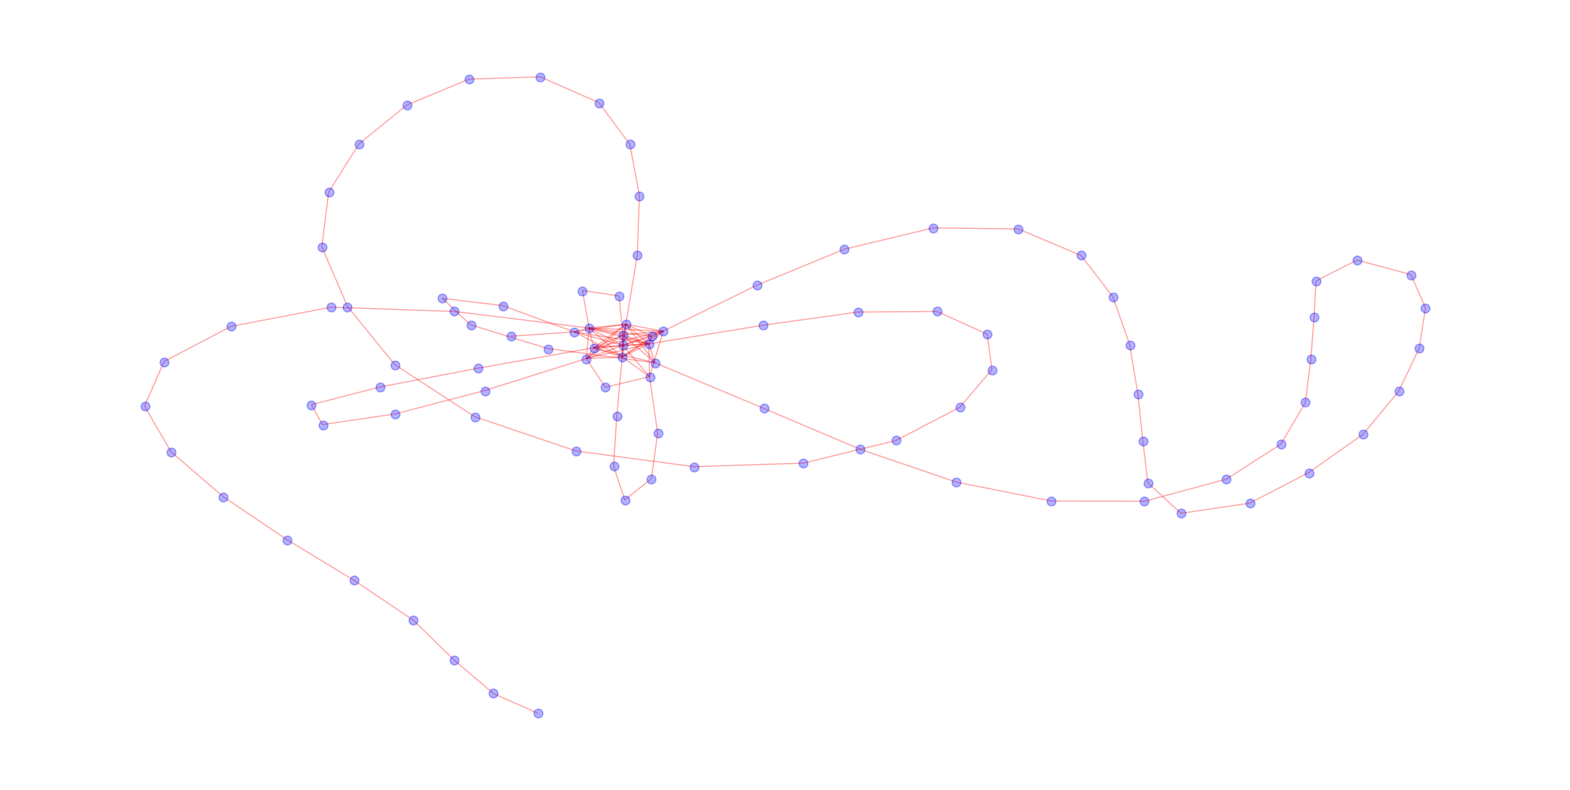

In [287]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
nx.draw(G,
        ax= ax,
        pos=nx.get_node_attributes(G, 'pos'),
        node_size=40,
        alpha=0.3,
        node_color='b',
        edge_color='r')

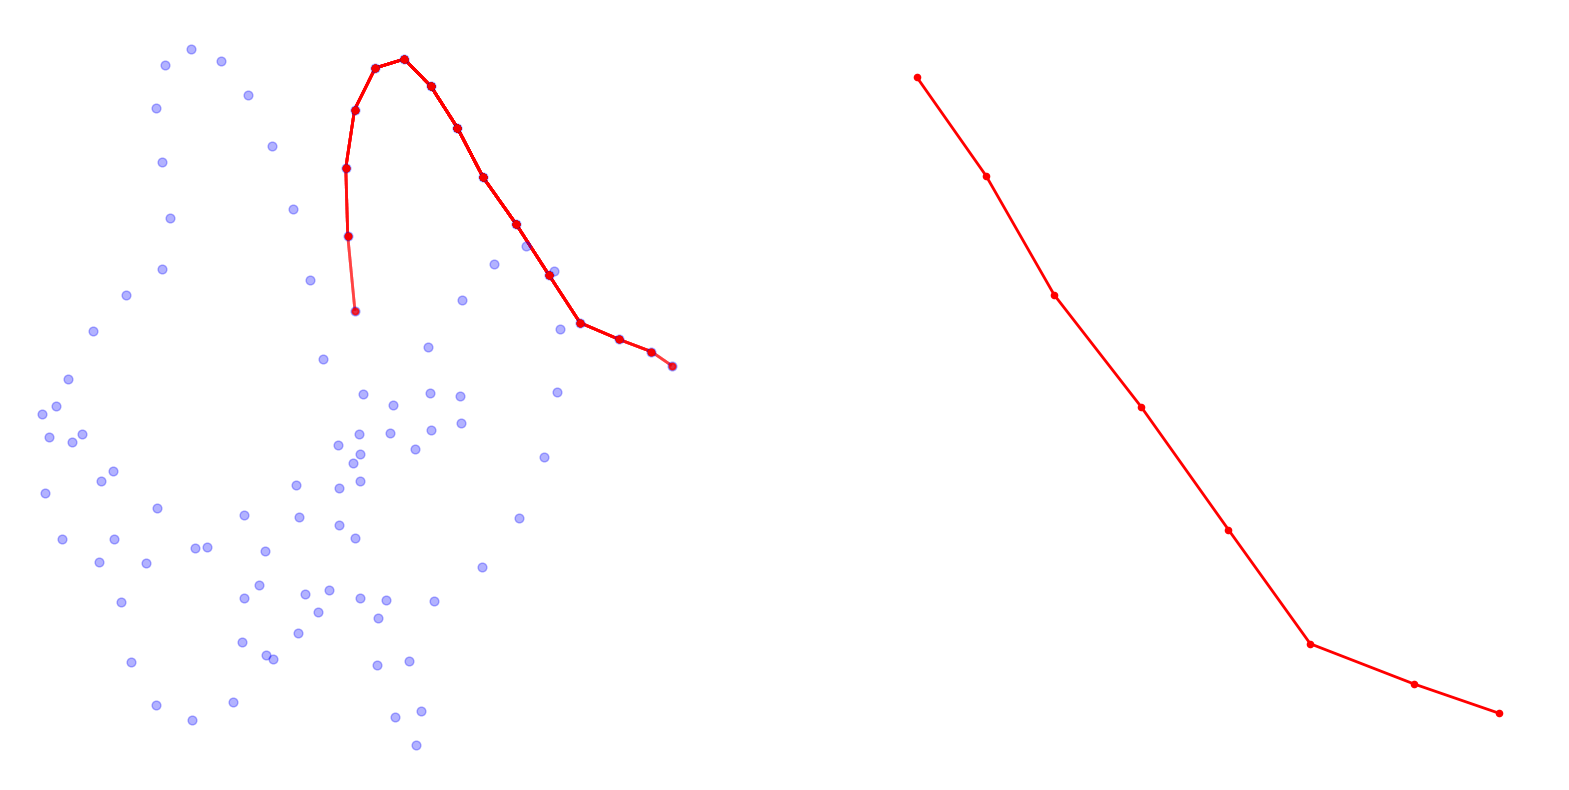

In [264]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G,
                       ax=ax,
                       pos=nx.get_node_attributes(G, 'pos'),
                       node_size=40,
                       alpha=0.3,
                       node_color='b')
first_batch = list(loader)[0][0]
for i in range(m):
        nodelist = first_batch[i].tolist()
        walk = nx.path_graph(len(nodelist))
        nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')


        nx.draw(walk,
                node_size=20,
                node_color='r',
                ax=ax,
                pos=nx.get_node_attributes(walk, 'pos'),
                width=2,
                edge_color='r',alpha = 0.1)
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk,
        node_size=20,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'),
        width=2,
        edge_color='r')

In [270]:
for i in list(loader)[1][0]:
    print(i)

tensor([ 8,  9, 10, 11, 12, 13, 14, 15])
tensor([ 9, 10, 11, 12, 13, 14, 15, 16])
tensor([10, 11, 12, 13, 14, 15, 16, 44])
tensor([11, 12, 13, 14, 15, 16, 41, 44])
tensor([12, 13, 14, 15, 96, 97, 97, 97])
tensor([13, 14, 15, 96, 97, 97, 97, 97])
tensor([14, 15, 16, 44, 60, 61, 62, 63])
tensor([15, 16, 44, 52, 60, 61, 62, 63])
tensor([ 8,  9, 10, 11, 12, 13, 14, 15])
tensor([ 9, 10, 11, 12, 13, 14, 15, 17])
tensor([10, 11, 12, 13, 14, 15, 16, 17])
tensor([11, 12, 13, 14, 15, 16, 17, 44])
tensor([12, 13, 14, 15, 16, 17, 52, 53])
tensor([13, 14, 15, 16, 44, 60, 61, 62])
tensor([14, 15, 96, 97, 97, 97, 97, 97])
tensor([15, 16, 17, 60, 61, 62, 63, 64])
tensor([ 8,  9, 10, 11, 12, 13, 14, 15])
tensor([ 9, 10, 11, 12, 13, 14, 15, 17])
tensor([10, 11, 12, 13, 14, 15, 96, 97])
tensor([11, 12, 13, 14, 15, 16, 91, 92])
tensor([12, 13, 14, 15, 16, 41, 60, 61])
tensor([13, 14, 15, 17, 52, 60, 61, 62])
tensor([14, 15, 16, 91, 92, 93, 94, 95])
tensor([15, 16, 17, 43, 44, 60, 61, 62])
tensor([ 8,  9, 

In [169]:
model = Node2Vec(edges_tensor, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=8, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [170]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [171]:
price = get_stock_price(data,tickers)

In [172]:
dist = np.mean((price[1:31]/price[0,None]-1)>0.03,axis=0)
dist.shape

(98,)

In [173]:
less = dist>=0.35
greater = dist>=0.7
ret = 1*greater + 1*less
print({i:sum(ret==i)/len(ret) for i in [0,1,2]})
ret = torch.tensor(ret,dtype=torch.long,device=device)


{0: 0.35714285714285715, 1: 0.29591836734693877, 2: 0.3469387755102041}


In [174]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z, ret,
                     z, ret,
                     max_iter=150)
    return acc

In [175]:
for epoch in range(1, 50):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 01, Loss: 8.5671, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 02, Loss: 6.1241, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 03, Loss: 4.8224, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 04, Loss: 4.0013, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 05, Loss: 3.6063, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 06, Loss: 3.2830, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 07, Loss: 3.0933, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 08, Loss: 2.9775, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 09, Loss: 2.9100, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 10, Loss: 2.6980, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 11, Loss: 2.6899, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 12, Loss: 2.6963, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 13, Loss: 2.5942, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 14, Loss: 2.5880, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 15, Loss: 2.5732, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 16, Loss: 2.5298, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 17, Loss: 2.5060, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 18, Loss: 2.5712, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 19, Loss: 2.6090, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 20, Loss: 2.5177, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 21, Loss: 2.5856, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 22, Loss: 2.5147, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 23, Loss: 2.5592, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 24, Loss: 2.5291, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 25, Loss: 2.5808, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 26, Loss: 2.5740, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 27, Loss: 2.5139, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 28, Loss: 2.5067, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 29, Loss: 2.5601, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 30, Loss: 2.5860, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 31, Loss: 2.5367, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 32, Loss: 2.5150, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 33, Loss: 2.5292, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 34, Loss: 2.5070, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 35, Loss: 2.5845, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 36, Loss: 2.5055, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 37, Loss: 2.6006, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 38, Loss: 2.5418, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 39, Loss: 2.5207, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 40, Loss: 2.5531, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 41, Loss: 2.5185, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 42, Loss: 2.5249, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 43, Loss: 2.5015, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 44, Loss: 2.5532, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 45, Loss: 2.4927, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 46, Loss: 2.5621, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 47, Loss: 2.5019, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 48, Loss: 2.5424, Acc: 1.0000


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 49, Loss: 2.4978, Acc: 1.0000


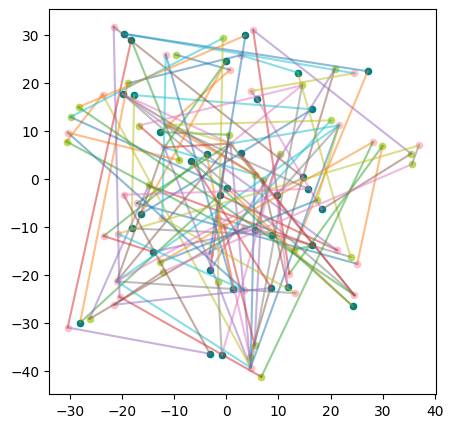

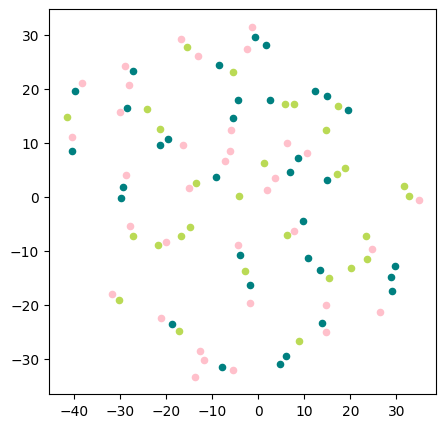

In [180]:
@torch.no_grad()
def plot_points(num_of_nodes,colors, edges = None):
    model.eval()
    z = model(torch.arange(num_of_nodes, device=device))
    z = TSNE(n_components=2,perplexity=5).fit_transform(z.cpu().numpy())
    y = ret.cpu().numpy()
    plt.figure(figsize=(5, 5))
    for i in range(3):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    if edges:
        for e in edges:
            plt.plot(z[e,0],z[e,1],alpha = 0.5)
    plt.axis('on')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(m,colors,G.edges)
plot_points(m,colors)

In [ ]:
import networkx as nx
def read_graph(our_format):
	'''
	Reads the input network in networkx.
	'''
	if len(our_format)==2:
		lines = [str(x[0])+' '+str(x[1]) for x in zip(*our_format)]
	else:
		lines = [str(x[0])+' '+str(x[1]) for x in our_format]
	G = nx.parse_edgelist(lines, nodetype=int)
	for edge in G.edges():
		G[edge[0]][edge[1]]['weight'] = 1
	G = G.to_undirected()

	return G

In [7]:
import node2vector as node2vec
p = 0.25
q = 0.25
num_walks =5
walk_length = 5
nx_G = read_graph(edges)
G = node2vec.Graph(nx_G, p, q)
G.preprocess_transition_probs()
walks = G.simulate_walks(num_walks, walk_length)

Walk iteration:
1 / 5
2 / 5
3 / 5
4 / 5
5 / 5


In [8]:
nodelist = next(enumerate(loader))[1][0][0].tolist()
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G, 
                       ax=ax,
                       pos=nx.get_node_attributes(G, 'pos'), 
                       node_size=5,
                       alpha=0.3,
                       node_color='b')
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 

NameError: name 'loader' is not defined